In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from models.yolov4 import CSPDarknet53_SPP_PAN
from models.common import *
from utility.loss_function import *
from utility.utilities import *
from utility.boxes import *
from utility.dataset import *
from utility.dataset_api import *
from utility.display import *

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print("Using GPU: {}".format(use_cuda))

# ds = CocoDatasetAPITrain()
ds = CocoDatasetTrain()
dl = load_dataloader(ds, batch_size=1)

model = CSPDarknet53_SPP_PAN()
model.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
model.eval()

Using GPU: False


    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): Identity()
            )
          )
          (activation): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (6): BottleneckBlock(
          (conv1): Conv2dBlock(
            (conv_layer): Sequential(
              (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): LeakyReLU(negative_slope=0.01, inplace=True)
            )
          )
          (conv2): Conv2dBlock(
            (conv_layer): Sequential(
              (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): Identity()
            )
          )
          (activation): LeakyReLU(negative_slope=0.01, inplace=True)
        

tensor(0.1200)


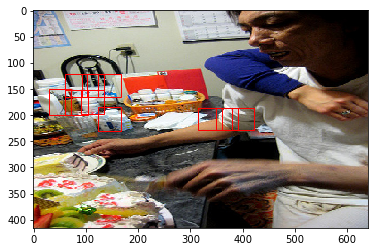

In [47]:
for i, batch in enumerate(dl):
    with torch.no_grad():
        images, targets = batch
        images = images.to(device=device)
        
        preds = model(images)[-1]
        
        preds = split_output(preds, device)
        
        preds[0][:,:,:,:,0:2] = ACTIVATIONS['sigmoid'](preds[0][:,:,:,:,0:2])
        preds[1] = ACTIVATIONS['sigmoid'](preds[1])
        preds[2] = ACTIVATIONS['sigmoid'](preds[2])
        
        pred_boxes = prediction_to_boxes(preds[0], 's_scale', device)

        nH, nW = pred_boxes.shape[1], pred_boxes.shape[2]

        boxes_coords, best_boxes, idx_best_boxes = filter_boxes(pred_boxes, preds[1], preds[2], threshold=0.15)

        boxes_coords *= torch.Tensor([[32.0, 32.0, 32.0, 32.0]])

        boxes_coords, best_boxes, idx_best_boxes = non_max_suppression(boxes_coords, best_boxes, idx_best_boxes, (416.0, 640.0), iou_threshold=0.6, max_boxes=10)

        show_prediction(images.squeeze(0), boxes_coords)

    break